----
>「私が作り出してきた敵によって、私を判断してもらいたい」
>
>フランクリン・ルーズベルト
----

ここでは、特に応用として重要なGANをピックアップする
- Efficient GAN
  - GANを用いた異常検知
- SAGAN
  - Self-Attensionを初めて導入したGAN

# Efficient GAN

GANで異常検知を行う
- 普通にラベルがついたデータがあればどのような方法でも学習できる
- しかしながら、 異常データが極めて少ないか存在しない(もしくは正常データが極めて少ないか存在しない)データセットの場合は学習が困難になる
- なお、ラベルがついているので、この場合も教師あり学習となる

特に正常データしかない場合での異常検知について考える
- 正常データのみで自己生成モデルを作成する
- その潜在空間$z$には、正常データの特徴が抽出されているはずである
- 未知なデータ$x'$に対し、$z$を操作して、$x'$が生成できれば正常、できなければ異常と判断できる
  - この方針がAnoGAN
- しかしながら、AnoGANは$z$を求めるためにバックプロパゲーションと最適化を繰り返し行うことが必要で計算時間がかかるため採用しにくい
  - $z$以外のパラメータを固定し、$z$を誤差逆伝搬で定めていくという方針
  - 一方でStyleGANにおける$z$の訴求などに通じるため考え方は重要

Efficient GANは潜在表現$z$を入力画像から求めるモデル(Encoder:E)を構築する
- このモデルに異常データを投入した際、少ないロスで自己生成できれば正常、ロスが大きくうまく自己生成できない場合は異常と判断できる
- 次のような方針が考えられる
  - まず、GeneratorとDiscriminatorを準備し、普通にGとDを学習
  - 生成したGに対して、ありえる画像と潜在表現$z$のペアを大量に取得、このデータセットを用いてEを生成(事後モデル獲得方式)
- しかしながら、この方針はうまくいかないことが知られている

そこで、Efficient GANでは、GとDを学習する際に、Eも同時に学習させる(同時モデル獲得方式)

## なぜ事後モデル獲得はうまくいかないのか？

理論的には証明されていないが、感覚的には理解できる
- Gに対してありえる画像と潜在表現$z$のペアを大量に取得するため、$z$に適当な値をいれて画像を生成させるなどが考えられるが、乱数を用いた場合$z$における適切な表現空間を利用しているかどうかが疑問
- Gの学習に利用した入力画像データを利用することはできないため、Eの表現空間がGとは異なる
- GANはGeneratorとDiscriminatorを競わせるようにして学習させることで、精度の良い学習モデルを構築していることから、Encoderについても競わせて学習させなければ同様に精度のよいモデルを獲得できないのではないか？という疑問

実験的説明は存在する(下図参照)
- 評価対象モデルは次の通り
  - G, D, Eを一緒に学習させるGAN同時獲得
  - 学習用入力データセット$x$を用いて、G, Dを学習、Gから、Eを学習させるGAN事後獲得
  - VAE、この場合GとEは同一
- 評価項目は次の通り
  - Gの潜在空間マップ$z$
  - Eに全潜在空間マップ$z$を入力した際の出力、再構成データ
  - Eに異なる入力$X$を入力した際の出力
- 入力はカウス分布を空間の$5\times 5$に配置した学習用データセットと、全体に分布させた検証用データセット

これに従えば、
- Gの潜在空間マップ$z$に関して
  - $z$は隙間がなく円形の方が生成の時に都合がよく、この点で同時学習は優れている
    - 円形ではない場合白い隙間に入るとありえないデータが生成されるため
    - 円形であると潜在空間内を自由に動き回りやすい
  - 同時学習は表現空間をめいいっぱい利用できる
- Eに全潜在空間マップ$z$(あり得る値のみ)を入力した場合の出力
  - 元のデータセットに忠実に戻るのはVAE
  - 事後獲得は元に戻れない欠損が生じ、同時獲得は元に存在しないデータが現れる
- Eに異なる入力$X$(ありえない値も含めて)を入力した場合の出力
  - 理想的には元の$x$に該当しないデータは排除されていた方がよい
  - GAN同時獲得は、VAEよりもエラーが少ない
    - 一方で、text-to-imageのDiffusionのように表現力が高いことが望ましい場合もあることに注意すること
  - GAN事後獲得は、そもそも表現しきれていない

<img src="http://class.west.sd.keio.ac.jp/dataai/text/ganencoders.png" width="700">

つまり、Eの学習に学習用入力データセット$x$を利用するのがよいといえる

## G, D, Eの同時学習

生成器$G$、識別器$D$と同時にエンコーダ$E$を学習させ、$E$の作成に教師データ$x$を用いるため、Bidirectional Generative Adversarial Networks (BiGAN)の構造を利用する

- BiGANはDへ画像$x$ノイズ$Z$をペアにして$(x,Z)$を入力
  - 上記潜在空間$z$は生成された潜在空間で、$Z$はノイズで構成した表現したい空間のサンプルであるため別物であるが、モデルが獲得した内部表現という意味では近しい
- $D$は$x$と$E(x)$のペアなのか、$G(Z)$と$Z$のペアなのかを区別する

## ロス関数の設計

$D$の損失関数はこれまで同様、次の式を最小化するように学習すればよい
$$-\sum^M_{i=1}\log D(x_i, E(x_i))-\sum^M_{i=1}\log (1-D(G(z_j), z_j))$$

$G$もこれまで同様、$D$を騙すように学習するため、この式を大きくするように学習すればよく、そのためには、
$$\sum^M_{i=1}\log (1-D(G(Z_j), Z_j))$$
を最小化させるように学習すればよいが、このままでは学習初期で見破る可能性が高い場合、$\log 1=0$となり、損失がゼロになりやすい
- 結果として学習が進みにくい

そこで、
$$-\sum^M_{i=1}\log D(G(Z_j), Z_j)$$
を最小化するように学習すればよい

$E$は、$E(x)$が$Z$となるように学習してほしい
- $G$は$G(Z)$が$x$となるように学習する
- $E$としては$(x,E(x))$と$(G(Z),Z)$の区別がつかなければよい

$E$は$D$が最小化しようとしている式を最大化するように学習すればよいことから、上記$D$の損失関数の符号を反転させた式でよく、
$$\sum^M_{i=1}\log D(x_i, E(x_i))$$
となる

但し、上記と同様に学習が進みにくいという問題が発生するため、
$$\sum^M_{i=1}\log(1-D(x_i, E(x_i)))$$
の最大化と考え、さらに、
$$-\sum^M_{i=1}\log(1-D(x_i, E(x_i)))$$
の最小化として実装する



## Efficient GANの実装

ここでは、MNISTを用いて異常検知を行う
- 一部の数字で学習
- 異なる数字を異常と判断させる

### 事前準備

In [ ]:
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import os
import urllib.request
import zipfile
import tarfile
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# なくともよいが、固定しておく
torch.manual_seed(1000)
np.random.seed(1000)
random.seed(1000)

### dataフォルダの作成とMNISTダウンロード

In [ ]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home="./data/", as_frame=False)
X = mnist.data
y = mnist.target

フォルダdataの下にフォルダimg_78を作成

In [ ]:
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

### 学習用データの抽出

MNISTから数字7、8の画像を抽出し、data/img_78フォルダに画像を保存する
- 画像はそれぞれ200枚
- サイズは$28 \times 28$[リンクテキスト](https://)

In [ ]:
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する
for i in range(len(X)):
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count7+=1
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count8+=1
    if (count7>=max_num) and (count8>=max_num):
        break

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-54-6cc0651124a4>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "7") and (count7<max_num):
<ipython-input-54-6cc0651124a4>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "8") and (count8<max_num):


### 学習用データの抽出

MNISTから数字2、7、8の画像を抽出し、data/testフォルダに保存する
- 画像はそれぞれ200枚
- サイズは$28 \times 28$

In [ ]:
# フォルダdataの下にフォルダtestを作成する
data_dir_path = "./data/test/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)
# 上記で7,8の画像を作成するのに使用したindexの最終値
i_start = i+1
i_start

2244

MNISTから数字2、7、8の画像だけフォルダdata/test/img_2_, img_7_, img_8_に保存
- 画像はそれぞれ5枚

In [ ]:
count2=0
count7=0
count8=0
max_num=5  # 画像は5枚ずつ作成する
for i in range(i_start,len(X)):  # i_startから始める
    # 画像2の作成
    if (y[i] is "2") and (count2<max_num):
        file_path="./data/test/img_2_"+str(count2)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count2+=1
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/test/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count7+=1
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/test/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count8+=1

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-56-97e295b1cadb>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "2") and (count2<max_num):
<ipython-input-56-97e295b1cadb>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "7") and (count7<max_num):
<ipython-input-56-97e295b1cadb>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (y[i] is "8") and (count8<max_num):


### Generatorの実装

白黒画像であるため出力チャネルは1つだけである




In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(z.shape[0], 128, 7, 7)  # 転置畳み込み層に入れるためにテンソルの形を整形
        out = self.layer3(out)
        out = self.last(out)
        return out

#### Generatorの動作確認

学習前なので、ひとまずノイズのような画像がでればよい

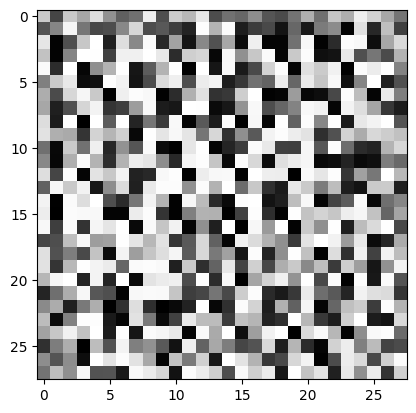

In [ ]:
G = Generator(z_dim=20)
G.train()
# 入力乱数
input_z = torch.randn(2, 20)  # バッチノーマライゼーションがあるのでミニバッチ数は2以上
# 偽画像を出力
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

### Discriminatorの実装

BiGANモデルに準拠しており、画像データ$x$に加えて入カノイズ$Z$も入力する
- 2つの入力は畳み込み層および全結合層で別々に処理された後、torch.cat(）を用いて結合し、もう一度全結合層でセットで処理する
- 異常度の計算には、最後の識別結果を出力する全結合層の1つ手前の層の特徴量を使用するため、これも出力させる

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        # 画像側の入力処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))  # 白黒画像なので入力チャネルは1つだけ
        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        self.z_layer1 = nn.Linear(z_dim, 512)  # 乱数側の入力処理
        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))
        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):
        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        # 乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)
        x_out = x_out.view(-1, 64 * 7 * 7)  # x_outとz_outを結合し、全結合層で判定
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換
        out = self.last2(out)
        return out, feature  # 最終層と一つ前の層をセットで出力

#### Discriminatorの動作確認

特に現状で何か意味のある値が得られるわけではないが、d_outに真偽の確率が出力される
- Sigmoidをかけて(0,1)に変換

In [ ]:
D = Discriminator(z_dim=20)
input_z = torch.randn(2, 20)  # 偽画像を生成
fake_images = G(input_z)
d_out, _ = D(fake_images, input_z)  # 偽画像をDに入力
print(nn.Sigmoid()(d_out))  # 出力d_outにSigmoidをかけて0から1に変換

tensor([[0.5372],
        [0.5378]], grad_fn=<SigmoidBackward0>)


### Encoderの実装

画像を$z$に変換する
- 出力の次元は入カノイズ$z$の次元数でありここでは20次元

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))  # 注意：白黒画像なので入力チャネルは1つだけ
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))
        self.last = nn.Linear(128 * 7 * 7, z_dim)  # ここまでで画像のサイズは7×7になっている
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 128 * 7 * 7)  # FCに入れるためにテンソルの形を整形
        out = self.last(out)
        return out

#### Encoderの動作確認

学習前なので意味はそれほどないが実行して、サイズなどを確認する

In [ ]:
E = Encoder(z_dim=20)
x = fake_images  # 入力する画像データでfake_imagesは上のGで作成した画像
z = E(x)  # 画像からzをEncode
print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[ 0.0917, -0.0126,  0.5139, -0.0347,  0.5138, -0.0078,  0.3746, -1.1431,
          0.3216, -0.1032,  0.7942,  0.9656, -0.5963,  0.1975, -0.3068, -0.6136,
         -0.0066,  0.1029,  0.0314, -0.6309],
        [-0.7853, -0.2007,  0.6585, -0.2960,  0.2135, -0.0486, -0.0174, -0.0625,
          0.6132, -0.5661, -0.5322,  0.4024, -0.0510,  0.5139, -0.1560,  0.3418,
         -0.7115,  0.7870,  0.4371,  0.0263]], grad_fn=<AddmmBackward0>)


### DataLoaderの作成と動作確認

学習、検証の画像データとアノテーションデータへのファイルパスリストを作成

In [ ]:
def make_datapath_list():
    train_img_list = list()  # 画像ファイルパスを格納
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
    return train_img_list

 画像の前処理クラスを定義

In [ ]:
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    def __call__(self, img):
        return self.data_transform(img)

画像のDatasetクラス。PyTorchのDatasetクラスを継承

In [ ]:
class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):  # 画像の枚数を返す
        return len(self.file_list)

    def __getitem__(self, index):  # 前処理をした画像のTensor形式のデータを取得
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒
        # 画像の前処理
        img_transformed = self.transform(img)
        return img_transformed

DataLoaderの動作確認

In [ ]:
# ファイルリストを作成
train_img_list=make_datapath_list()
# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))
# DataLoaderを作成
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 28, 28])


## Efficient GANの学習

$D$、$G$、$E$をDataLoaderを使用して学習させる

- $D$を学習する
- 続いて$G$と$E$を学習させる
- $D$学習率は、$G$、$E$の学習率よりも低く設定
  - $D$は画像とノイズのペアで識別するため、画像だけの場合よりも簡単
  - 今回のような画像の枚数が少ない状況では、学習率を低くして学習進度を落としたほうが安定する
  - もちろん、これはロス関数に計数を与えて反映度合いを調整して解決するという方法も存在するが、今回は学習率を変更した方が直接的

ここではBCEWithLogitsLossを利用
  - 入力にシグモイド（logit）を施してからバイナリークロスエントロピーを算出

途中、型が入力Longと期待するFloatが異なるためBCEロジットロスがエラーとなるのを避けるため、型を揃えている
  - PyTorchはユーザーから隠れたコピーを極力避ける設計方針を選択しており冗長かもしれないが、制御しやすい(中の人談)
            

In [ ]:
D_loss = []
G_loss = []
E_loss = []
def train_model(G, D, E, dataloader, num_epochs):
    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])
    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64
    G.to(device)
    E.to(device)
    D.to(device)
    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに
    torch.backends.cudnn.benchmark = True  # ネットワークがある程度固定であれば、高速化させる
    num_train_imgs = len(dataloader.dataset)  # 画像の枚数
    batch_size = dataloader.batch_size
    iteration = 1  # イテレーションカウンタをセット
    logs = []
    for epoch in range(num_epochs):  # epochのループ
        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和
        for imges in dataloader: # データローダーからminibatchずつ取り出すループ
            # ミニバッチがサイズが1の場合のBatchNormの問題を回避する
            if imges.size()[0] == 1:
                continue
            # 正解ラベルと偽ラベルを作成
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            imges = imges.to(device)
            # Discriminatorの学習
                # 真の画像を判定
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)
                # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
                # 誤差を計算 d_out_realとlabel_realの型と配列の形が異なるため直接比較できず揃える
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            # Generatorの学習
                # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
                # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            # Encoderの学習
                # 真の画像のzを推定
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)
                # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()
            # 結果の記録
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1
        # epochごとのlossと正解率
        t_epoch_finish = time.time()
        D_loss.append(epoch_d_loss/batch_size)
        G_loss.append(epoch_g_loss/batch_size)
        E_loss.append(epoch_e_loss/batch_size)
        if(epoch % 20 == 0):
          print('timer:  {:.4f} sec. : epoch {}/{} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            t_epoch_finish - t_epoch_start, epoch, num_epochs, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        t_epoch_start = time.time()
    print("総イテレーション回数:", iteration)
    return G, D, E

### ネットワークの初期化

ネットワークの重みを初期化しておく

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)
# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (x_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (z_layer1): Linear(in_features=20, out_features=512, bias=True)
  (last1): Sequential(
    (0): Linear(in_features=3648, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last2): Linear(in_features=1024, out_features=1, bias=True)
)

### 学習・検証

15分ほど必要

In [ ]:
num_epochs = 2000
G_update, D_update, E_update = train_model(G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

timer:  0.3547 sec. : epoch 0/2000 || Epoch_D_Loss:0.1498 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.0768
timer:  0.2887 sec. : epoch 20/2000 || Epoch_D_Loss:0.0703 ||Epoch_G_Loss:0.1405 ||Epoch_E_Loss:0.1530
timer:  0.3176 sec. : epoch 40/2000 || Epoch_D_Loss:0.0155 ||Epoch_G_Loss:0.2880 ||Epoch_E_Loss:0.3409
timer:  0.3088 sec. : epoch 60/2000 || Epoch_D_Loss:0.0079 ||Epoch_G_Loss:0.3849 ||Epoch_E_Loss:0.4006
timer:  0.3027 sec. : epoch 80/2000 || Epoch_D_Loss:0.0110 ||Epoch_G_Loss:0.4005 ||Epoch_E_Loss:0.4052
timer:  0.2941 sec. : epoch 100/2000 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.2611 ||Epoch_E_Loss:0.3135
timer:  0.3089 sec. : epoch 120/2000 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.2599 ||Epoch_E_Loss:0.2456
timer:  0.2941 sec. : epoch 140/2000 || Epoch_D_Loss:0.0948 ||Epoch_G_Loss:0.1686 ||Epoch_E_Loss:0.1985
timer:  0.2898 sec. : epoch 160/2000 || Epoch_D_Loss:0.0998 ||Epoch_G_Loss:0.1503 ||Epoch_E_Loss:0.1576
timer:  0.2847 sec. : epoch 180/2000 || Epoch_D_Loss:0.1173 ||Epoch_G_

ロス曲線の描画

- 最初は不安定かもしれないが、最終的にはGが上がり、Dが下がることで両者がくっきりと区別されることで学習の進度をみることができる

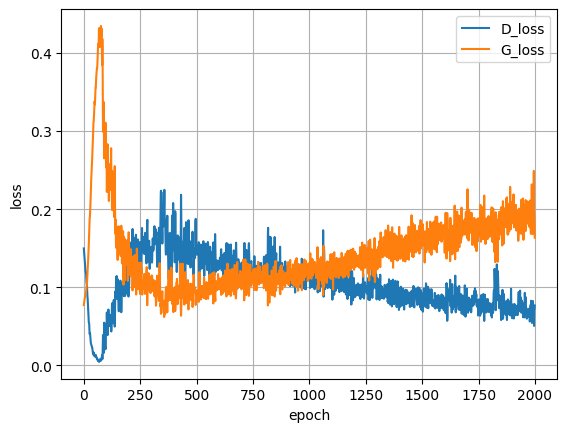

In [ ]:
plt.clf()
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

### 生成画像と訓練データを可視化

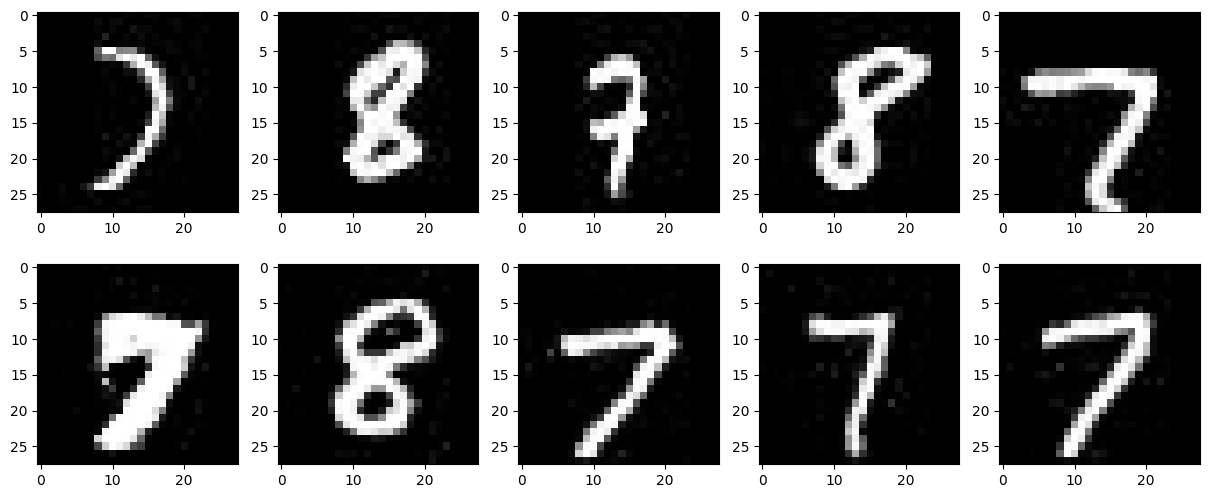

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))
# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

## テスト画像で異常検知

テスト用のDataLoaderを作成
- 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成

In [ ]:
def make_test_datapath_list():
    train_img_list = list()  # 画像ファイルパスを格納
    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        img_path = "./data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        img_path = "./data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
    return train_img_list
test_img_list = make_test_datapath_list()  # ファイルリストを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(  # Datasetを作成
    file_list=test_img_list, transform=ImageTransform(mean, std))
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(  # DataLoaderを作成
    test_dataset, batch_size=batch_size, shuffle=False)

テストデータの確認

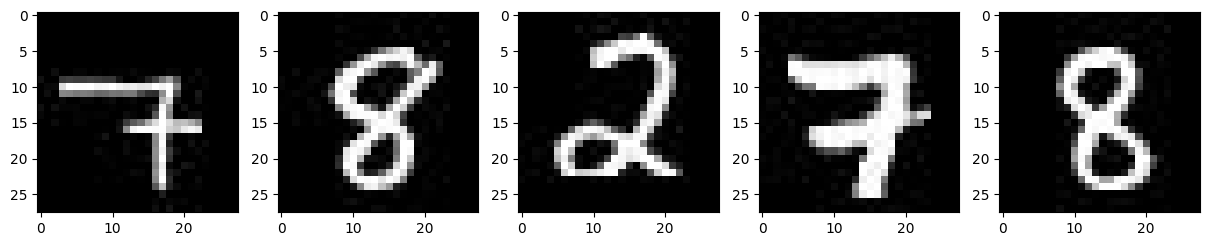

In [ ]:
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

### 異常度合いの計算

異常度を計算する関数Anomaly_scoreを実装

関数Anomaly_scoreへの入力はテスト画像$x$とエンコーダに$E$通して求めた入カノイズ$z$から生成器$G$で再構成したfake_imgに加えて、使用した入カノイズ$z$も与える

In [ ]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)
    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)
    return total_loss, loss_each, residual_loss

### 異常検知の実施

テスト画像に最もよく似た画像を生成する入カノイズ$Z$は、z_out_real = E_update(imges.to(device)）の1行で求まるため、低遅延で検知できる

数字の7、8の画像はよく似た7、8の画像を再構成できているが、教師データにない異常画像である数字の2は再構成できず7や8が生成されるはずである

異常度を計算すると正常画像がおおよそ200程度の値以下に対して、異常画像は250以上の値をとる
- この閾値を偽陽性、偽陰性のバランスから設定する

これを見ても分かる通り、異常度として、最終生成画像のMSEを利用するという方法も想定できるが、これは今回のケース限定の方法となる可能性がある

total loss： [175. 199. 275. 205. 196.]


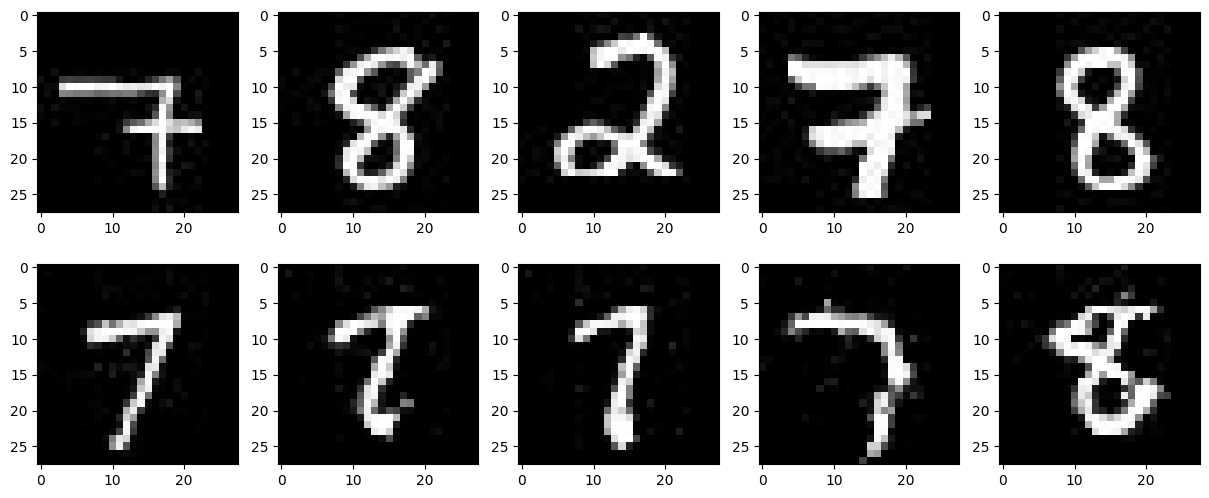

In [ ]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)
# 教師データの画像をエンコードしてzにしてから、Gで生成
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)
# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)
# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))
# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')

# 課題1 (Efficient GAN)

Effient GANについて、MNISTの数字を変更して確認しなさい
